# Slicing & Pricing Insurance Risk


This note explains how to compute the technical price of an insurance contract with additional policy structure in the form of risk bands (also known as layers or tranches). 

The technical price of a risk is essentially the expected loss to the insurer. The loss is driven by

 * _Ground-up Loss:_ Loss to the policy holder, typically represented using
   * _Frequency:_ Number of loss events per insured object and unit time
   * _Severity:_ loss amount given that a loss event occured
 * _Policy structure:_ Rules for computing gross loss (loss to the insurer) given ground-up loss

Frequency and severity are not known, so that they are distributions estimated from data. By contrast, the policy structure is deterministic and consists of a function that maps claim amount to loss. Typically, piecewise linear functions are used that allow to represent limit, deductible and risk bands.


## Ground-up Loss

We assume that number of loss events $n$ and their severities $s_1,\ldots,s_n$ are independent and that severities are iid. Then the distribution of ground-up losses $L_{\text{GU}}$ is

$$
p(L_{\text{GU}} = x) = \sum_n p(n) \,\int d^n \mathbf{s} \,\delta\left(x - \sum_{i=1}^n s_i\right) \, \prod_{i=1}^n p(s_i)
$$

In order to facilitate parameter estimation for the severity model, losses are normalized by total insured value $V$ (or some similar measure). With $s = V x$, $x \in [0, 1]$ a common distribution $f(x)$ can be used across insured objects,

$$
p(s = V x) = \frac{1}{V} f(x)
$$

While the full distribution looks intimidating, the expected (ground-up) loss has a simple expression by virtue of the independence assumptions:

$$
\begin{align}
\text{EL}_{\text{GU}} &= \mathbb{E}\left[L_{\text{GU}}\right] \\
    &= V \,\mathbb{E}[n] \, \mathbb{E}_{x \sim f}[x]
\end{align}
$$

The expected number of claims $\mathbb{E}\left[n\right]$ is often called the _rate_ with which losses occur and estimated using a model.

## Policy Structure and Gross Loss

Policy structures under consideration here consist of

 * a partition of the unit interval into $B$ non-overlapping sub-intervals - the risk bands. We denote the partition boundaries by $l_b, b \in \{0, \ldots, B\}$ where $l_0 = 0, l_B = 1$.
 * for each band $b \in \{1, \ldots B\}$, the fraction $f_b \in [0, 1]$ of the losses that are covered. Band $b$ covers the range $[l_{b - 1}, l_b]$.

The gross loss $L(x)$ given a band structure and the normalized ground-up loss is


$$
L(x) = \sum_{b=1}^B f_b \left[L_b(x) - L_{b - 1}(x)\right]
$$

where

$$
L_b(x) = \min(x, l_b)
$$

is the loss for a policy structure that consists of a single limit $l_b$.

As special cases,

 * the ground-up loss is recovered using a single band that spans the entire unit interval and setting $f_0 = 1$. Equivalently, we can use any number and location of bands as long as $\mathbf{f} = 1$.
 * the standard case with a single deductible $\delta$ and limit $\lambda$ is obtained with three bands $\mathbf{l} = (0, \delta, \lambda, 1)$ and fractions $\mathbf{f} = (0, 1, 0)$.

In the following, we consider the case where limits and deductibles apply to individual claims. Then the expected (gross) loss is

$$
\text{EL} = \underbrace{V \, \mathbb{E}[n] \, \mathbb{E}_{x\sim f}\left[x\right]}_{\text{ground-up loss}}\;\,\underbrace{\sum_{b = 1}^B f_b \frac{\mathbb{E}_{x \sim f}\left[L_b(x) - L_{b - 1}(x)\right]}{\mathbb{E}_{x\sim f}\left[x\right]}}_{\text{policy structure}}
$$

Note that the condition that policy structure applies to individual claims is important for the result to hold because the expectations are non-linear, so that for multiple claims the distribution of the sum of multiple claims has to be used (via convolution).

For the present case, the expectations can be computed using the so-called [exposure curve](https://www.casact.org/library/astin/vol27no1/99.pdf) of the distribution,

$$
\begin{align}
G(y) &= \frac{\mathbb{E}_{x\sim f}\left[\min(x, y)\right]}{\mathbb{E}_{x\sim f}\left[x\right]} \\
    &= \frac{\int_0^y \left[1 - F(x)\right] \, dx}{\int_0^1 \left[1 - F(x)\right] \, dx}
\end{align}
$$

so that we arrive at the compact result

$$
\text{EL} = \text{EL}_{\text{GU}} \, \sum_{b=1}^B f_b \left[G(l_b) - G(l_{b - 1})\right]
$$

## References

 * S. Bernegger, [The Swiss Re Exposure Curves and the MBBEFD Distribution Class](https://www.casact.org/library/astin/vol27no1/99.pdf)
 * C. Dutang, M. Gesmann, and G. Spedicato, [Exposure rating, destruction rate models and the
mbbefd package](https://cran.r-project.org/web/packages/mbbefd/vignettes/Introduction_to_mbbefd.pdf)

In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [22]:
figdir = Path('../assets/img/2019-04-20-slicing-and-pricing').resolve()
figdir.mkdir(exist_ok=True)

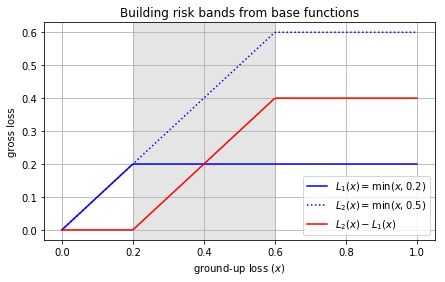

In [23]:
def h(x, limit):
    return np.minimum(x, limit)

fig, ax = plt.subplots(figsize=(7, 4))
x = np.linspace(0, 1, 200)
funcs = [h(x, .2), h(x, .6)]
funcs.append(funcs[1] - funcs[0])
for f, label, color in zip(
        funcs,
        ['$L_1(x) = \min(x, 0.2)$', '$L_2(x) = \min(x, 0.5)$', '$L_2(x) - L_1(x)$'],
        ['b-', 'b:', 'r']
        ):
    ax.plot(x, f, color, label=label)
    
ax.axvspan(.2, .6, color='k', alpha=.1)
ax.grid()
ax.legend()
ax.set_xlabel('ground-up loss ($x$)')
ax.set_ylabel('gross loss')
ax.set_title('Building risk bands from base functions')

fig.savefig(figdir.joinpath('risk-band.jpg'))